# Setting up the environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats
from scipy.stats import pearsonr
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

# Uploading the US-Accidents dataset
This dataset contains over 2 million accident records since 2016 from 49 states across the U.S. It was made available for download in May 2019 by Sobhan Moosavi. More information, including a link to download, is available at https://smoosavi.org/datasets/us_accidents.

The dataset contains information on accident location, driving conditions, and a variety of nearby traffic objects (i.e. bumps, roundabouts, stops). Each accident is also rated on 4-point scale for the severity of its impact on traffic, where 1 indicates a small impact and 4 indicates a large impact. 

In [2]:
acdnts = pd.read_csv("/Users/ellenpaigehoffman/Desktop/Thinkful/US_Accidents_May19.csv")

In [3]:
acdnts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2243939 entries, 0 to 2243938
Data columns (total 49 columns):
ID                       object
Source                   object
TMC                      float64
Severity                 int64
Start_Time               object
End_Time                 object
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description              object
Number                   float64
Street                   object
Side                     object
City                     object
County                   object
State                    object
Zipcode                  object
Country                  object
Timezone                 object
Airport_Code             object
Weather_Timestamp        object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             float64
Visibility(mi

In [4]:
acdnts.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,...,False,False,False,False,True,False,Day,Day,Day,Day


In [5]:
acdnts['Source'].unique()

array(['MapQuest', 'MapQuest-Bing', 'Bing'], dtype=object)

In [6]:
print("\nMissing Values:")
print(acdnts.isna().sum())


Missing Values:
ID                             0
Source                         0
TMC                       516762
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                  1727177
End_Lng                  1727177
Distance(mi)                   0
Description                    1
Number                   1458402
Street                         0
Side                           0
City                          68
County                         0
State                          0
Zipcode                      646
Country                        0
Timezone                    2141
Airport_Code               23664
Weather_Timestamp          47170
Temperature(F)             62265
Wind_Chill(F)            1852370
Humidity(%)                64467
Pressure(in)               57280
Visibility(mi)             71360
Wind_Direction             47190
Wind_Speed(mph)           

# Initial observations
There are 49 columns and 2,243,939 rows of data, expressed as strings, floats, booleans, and integers. Data was sourced from MapQuest and Bing.

For this project, I am interested in looking for correlations between adverse weather and accident occurrence and/or severity (accident impact on traffic). I will use the visibility, precipitation, and weather condition fields to indicate adverse weather. In my proposal, I hypothesized that accidents will be more severe when visibility is low.

Moosavi's documentation states precipitation will be null when there is no precipitation. First, I'll replace those null values with 0.

In [7]:
acdnts['Precipitation(in)'] = acdnts['Precipitation(in)'].fillna(0)

In [8]:
acdnts[['Precipitation(in)']].isna().sum()

Precipitation(in)    0
dtype: int64

In [9]:
acdnts.describe().round(2)

,TMC,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Number,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,1727177.00,2243939.00,2243939.00,2243939.00,516762.00,516762.00,2243939.00,785537.00,2181674.00,391569.00,2179472.00,2186659.00,2172579.00,1800985.00,2243939.00
mean,207.35,2.38,36.46,-94.86,37.44,-96.53,0.29,5625.28,61.23,26.04,65.93,30.04,9.12,8.84,0.01
std,19.41,0.55,4.96,17.09,5.13,17.99,1.53,11071.87,19.15,13.48,22.43,0.23,2.99,4.97,0.15
min,200.00,0.00,24.57,-124.62,24.57,-124.50,0.00,1.00,-77.80,-65.90,4.00,0.00,0.00,1.20,0.00
25%,201.00,2.00,33.48,-117.14,33.89,-117.87,0.00,803.00,48.90,19.20,50.00,29.92,10.00,5.80,0.00
50%,201.00,2.00,35.86,-88.18,38.04,-90.19,0.00,2672.00,63.00,28.70,68.00,30.03,10.00,8.10,0.00
75%,201.00,3.00,40.42,-80.85,41.39,-80.90,0.01,6846.00,75.90,36.40,85.00,30.15,10.00,11.50,0.00
max,406.00,4.00,49.00,-67.11,49.08,-67.11,333.63,961052.00,170.60,45.20,100.00,33.04,140.00,822.80,10.80


# Distribution of weather conditions
At first glance, the mean visibility (9.12 miles) is higher and the mean precipitation (0.01 inches) is lower than I would have predicted.

Let's look closer at the distribution of the weather conditions, precipitation, and visibility variables.

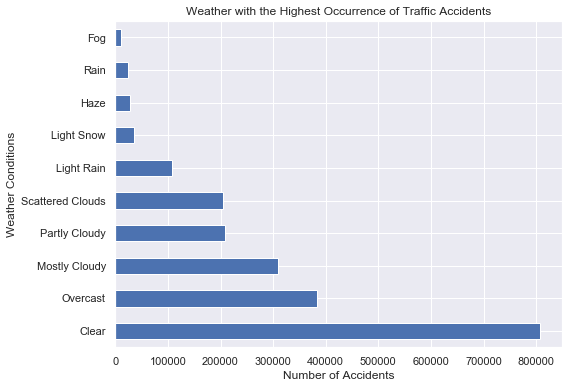

In [10]:
plt.figure(figsize=(8,6))
acdnts['Weather_Condition'].value_counts().head(10).plot('barh')
plt.xlabel('Number of Accidents')
plt.ylabel('Weather Conditions')
plt.title('Weather with the Highest Occurrence of Traffic Accidents');

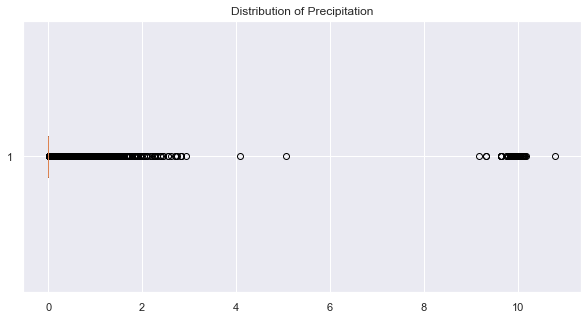

In [11]:
plt.figure(figsize=(10,5))
plt.boxplot(acdnts['Precipitation(in)'], vert=False)
plt.title('Distribution of Precipitation');

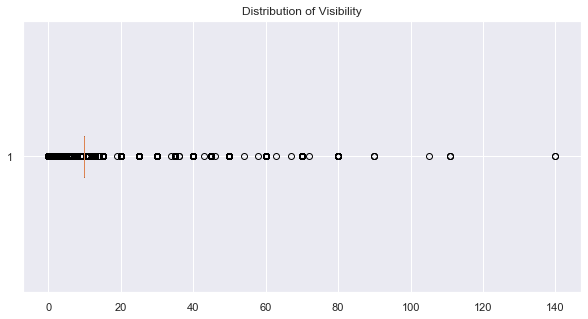

In [12]:
plt.figure(figsize=(10,5))
plt.boxplot(acdnts['Visibility(mi)'].dropna(), vert=False) # There are ~71,000 nulls (~3% of data)
plt.title('Distribution of Visibility');

As the bar graph above shows, the dataset is imbalanced, with many more accidents in clear weather than in any other weather condition. 

The boxplots representing precipitation and visibility also show this imbalance. In each, the majority of data is near the median, 10 miles for visibility and 0 inches for precipitation, suggesting clear conditions.

Oddly, there are no records showing 6-8 inches of precipitation. This may indicate an error in data collection.

# Clear vs. other weather
I'll split the dataset by clear conditions and all other conditions to see if precipitation and visibility distributions change.

In [13]:
acdnts_clr = acdnts[acdnts['Weather_Condition'] == 'Clear']
acdnts_unclr = acdnts[acdnts['Weather_Condition'] != 'Clear']

## Precipitation:

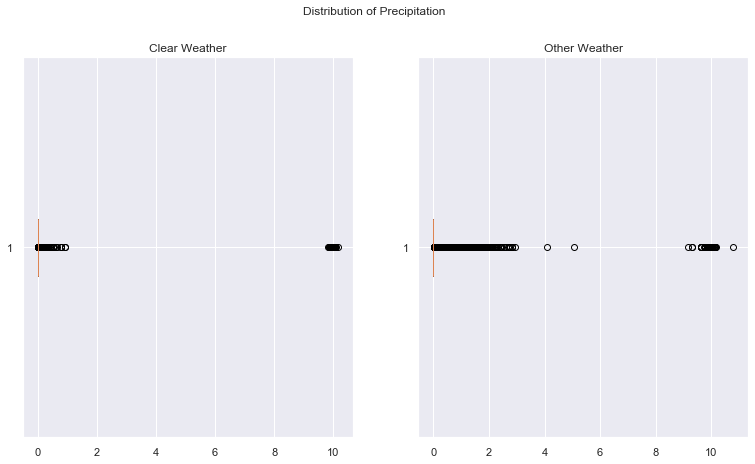

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,7))
fig.suptitle('Distribution of Precipitation')
ax1.boxplot(acdnts_clr['Precipitation(in)'], vert=False)
ax1.set_title('Clear Weather')
ax2.boxplot(acdnts_unclr['Precipitation(in)'], vert=False)
ax2.set_title('Other Weather');

The boxplots above appear to have similar distributions, showing that even when the weather was not clear, most accidents took place without precipitation. 

There are some records with over 10in of precipitation that were labeled as 'clear', indicating a data collection error. I'll drop these rows, then do a statistical analysis.

In [17]:
# finding index of the upper outliers in clear weather
to_drop = acdnts_clr[acdnts_clr['Precipitation(in)'] > 8].index

# number of instances
print('Values dropped:')
print(len(to_drop))

# dropping 162 rows
acdnts_clr.drop(to_drop , inplace=True)

Values dropped:
162


In [18]:
print('Clear Weather:')
print(acdnts_clr['Precipitation(in)'].describe().round(2))
print('---')
print('Other Weather:')
print(acdnts_unclr['Precipitation(in)'].describe().round(2))

Clear Weather:
count    808020.00
mean          0.00
std           0.00
min           0.00
25%           0.00
50%           0.00
75%           0.00
max           0.93
Name: Precipitation(in), dtype: float64
---
Other Weather:
count    1435757.00
mean           0.01
std            0.16
min            0.00
25%            0.00
50%            0.00
75%            0.00
max           10.80
Name: Precipitation(in), dtype: float64


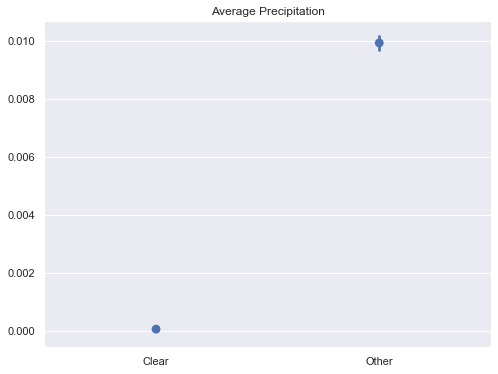

In [48]:
sns.set(rc={'figure.figsize':(8,6)})

g = sns.pointplot(data=[acdnts_clr['Precipitation(in)'],
                        acdnts_unclr['Precipitation(in)']], join=False)
                        
g.set(xticklabels = ['Clear', 'Other'])
plt.title('Average Precipitation');

In [20]:
# Calling t-test to see if difference in averages is significant
stats.ttest_ind(acdnts_clr['Precipitation(in)'], acdnts_unclr['Precipitation(in)'])

Ttest_indResult(statistic=-56.41500897214882, pvalue=0.0)

Average precipitation is 0.01 inches higher in other weather than in clear weather. While small, the difference is statistically significant. The standard deviation is also higher in other weather.

## Visibility:

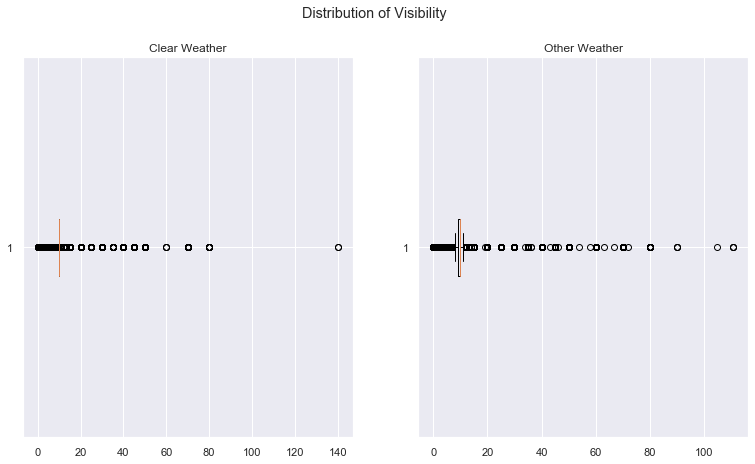

In [49]:
 # dropping rows where visibility is null (~71,000 total)
acdnts_clr.dropna(subset=['Visibility(mi)'], how='all', inplace=True)
acdnts_unclr.dropna(subset=['Visibility(mi)'], how='all', inplace=True)

# boxplots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,7))
fig.suptitle('Distribution of Visibility')
ax1.boxplot(acdnts_clr['Visibility(mi)'], vert=False)
ax1.set_title('Clear Weather')
ax2.boxplot(acdnts_unclr['Visibility(mi)'], vert=False)
ax2.set_title('Other Weather');

The visibility boxplots above show more variability around the median and outliers in other weather. Accidents with low visibility in clear weather may have taken place at night.

In [50]:
print('Clear Weather:')
print(acdnts_clr['Visibility(mi)'].describe().round(2))
print('---')
print('Other Weather:')
print(acdnts_unclr['Visibility(mi)'].describe().round(2))

Clear Weather:
count    805395.00
mean          9.86
std           1.65
min           0.00
25%          10.00
50%          10.00
75%          10.00
max         140.00
Name: Visibility(mi), dtype: float64
---
Other Weather:
count    1367048.00
mean           8.69
std            3.47
min            0.00
25%            9.00
50%           10.00
75%           10.00
max          111.00
Name: Visibility(mi), dtype: float64


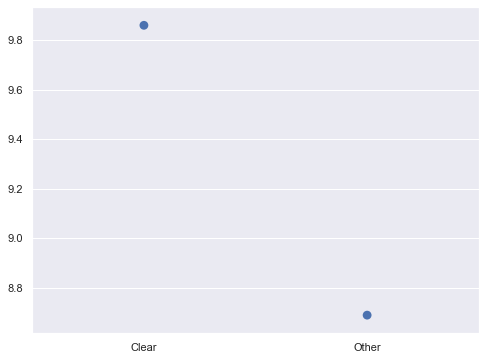

In [23]:
sns.set(rc={'figure.figsize':(8,6)})

g = sns.pointplot(data=[acdnts_clr['Visibility(mi)'],
                        acdnts_unclr['Visibility(mi)']], join=False)

g.set(xticklabels = ['Clear', 'Other']);

In [24]:
# T-test
stats.ttest_ind(acdnts_clr['Visibility(mi)'], acdnts_unclr['Visibility(mi)'])

Ttest_indResult(statistic=284.0692205462446, pvalue=0.0)

Average visibility is 1.17 miles more in clear than in other kinds of weather. This difference is also statistically significant.

# Exploring correlations between precipitation, visibility, and accident severity

In [25]:
# copying dataset
acdnts2 = acdnts.copy()
# dropping columns I am not using
acdnts2.drop(['Source', 'TMC', 'Start_Time', 'End_Time', 'End_Lat', 
             'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street',
             'Side', 'Country', 'Timezone', 'Airport_Code', 'Amenity',
             'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
             'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
             'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
             'Astronomical_Twilight'], axis=1, inplace=True)

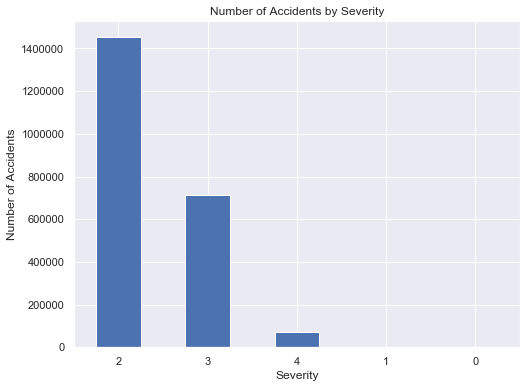

In [26]:
acdnts2['Severity'].value_counts().plot('bar')
plt.xlabel('Severity')
plt.xticks(rotation=0)
plt.ylabel('Number of Accidents')
plt.title('Number of Accidents by Severity')
plt.show()

Relationships between Visibility, Precipitation, and Accident Severity


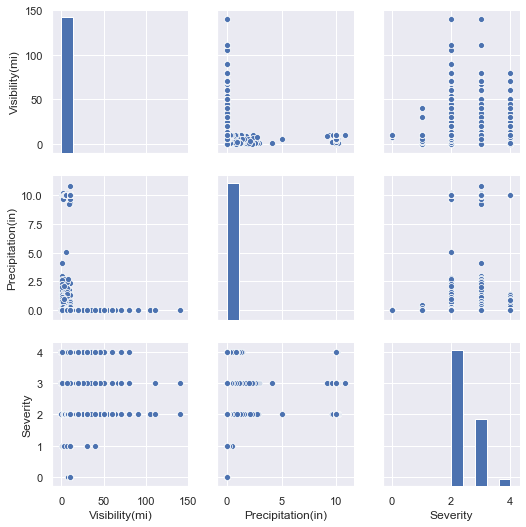

In [27]:
sns.pairplot(acdnts2, vars=['Visibility(mi)', 'Precipitation(in)', 'Severity'])
print("Relationships between Visibility, Precipitation, and Accident Severity")

Most accidents in the dataset are rated 2, followed by 3, then 4. There are not enough accidents rated 1 to analyze. Again, there is an imbalance here. 

Looking at the pair plots above, neither visibility nor precipitation seem to be correlated with higher severity. I'll find the Pearson correlation coefficients to confirm.

In [28]:
pearsonr(acdnts2['Severity'], acdnts2['Precipitation(in)'])

(0.005103574761565875, 2.0879957287617477e-14)

In [29]:
acdnts3 = acdnts2.copy() # copying the df
acdnts3.dropna(subset=['Visibility(mi)'], inplace = True) # dropping rows where visibility is null

pearsonr(acdnts3['Severity'], acdnts3['Visibility(mi)'])

(-0.009543188346200661, 6.087930575797077e-45)

The Pearson correlation coefficients do not indicate relationships between severity and precipitation or severity and visibility.

# Exploring average severity by weather condition

In [30]:
# creating a list with most common weather
top_weather = acdnts2['Weather_Condition'].value_counts().head(10) 
list(top_weather.index) 

['Clear',
 'Overcast',
 'Mostly Cloudy',
 'Partly Cloudy',
 'Scattered Clouds',
 'Light Rain',
 'Light Snow',
 'Haze',
 'Rain',
 'Fog']

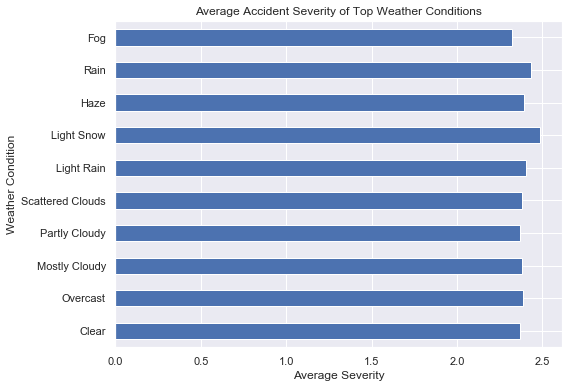

In [31]:
mean_severity = acdnts2.groupby('Weather_Condition')['Severity'].mean().sort_values(ascending=False)
mean_severity[list(top_weather.index)].plot('barh')
plt.xlabel('Average Severity')
plt.ylabel('Weather Condition')
plt.title('Average Accident Severity of Top Weather Conditions')
plt.show()

There is very little variability in average severity. Mean severity across the full dataset is 2.38, and the averages above are all between 2.25 and 2.5.

Next, I'll compare average severity in clear, light rain, and rain conditions to see if there is a significant difference.

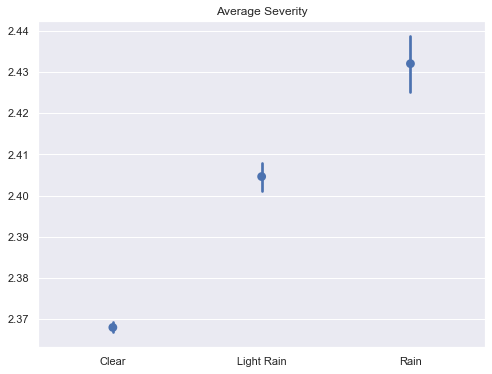

In [32]:
sns.set(rc={'figure.figsize':(8,6)})

clr_acdnts2 = acdnts2[(acdnts2['Weather_Condition'] == 'Clear')]
rain_acdnts2 = acdnts2[(acdnts2['Weather_Condition'] == 'Rain')]
lite_acdnts2 = acdnts2[(acdnts2['Weather_Condition'] == 'Light Rain')]

g = sns.pointplot(data=[clr_acdnts2['Severity'],
                        lite_acdnts2['Severity'],
                        rain_acdnts2['Severity']], join=False)
g.set(xticklabels = ['Clear', 'Light Rain', 'Rain'])
plt.title('Average Severity');

In [33]:
print('Clear and Light Rain:')
print(stats.ttest_ind(clr_acdnts2['Severity'], lite_acdnts2['Severity']))
print('---')

print('Clear and Rain:')
print(stats.ttest_ind(clr_acdnts2['Severity'], rain_acdnts2['Severity']))
print('---')

print('Light Rain and Rain:')
print(stats.ttest_ind(lite_acdnts2['Severity'], rain_acdnts2['Severity']))

Clear and Light Rain:
Ttest_indResult(statistic=-20.580774418776464, pvalue=4.2869766309024177e-94)
---
Clear and Rain:
Ttest_indResult(statistic=-18.160921968546813, pvalue=1.0875546276033734e-73)
---
Light Rain and Rain:
Ttest_indResult(statistic=-7.088021079334285, pvalue=1.3672084837285844e-12)


In [34]:
def get_95_ci(array_1, array_2):
    sample_1_n = array_1.shape[0]
    sample_2_n = array_2.shape[0]
    sample_1_mean = array_1.mean()
    sample_2_mean = array_2.mean()
    sample_1_var = array_1.var()
    sample_2_var = array_2.var()
    mean_difference = sample_2_mean - sample_1_mean
    std_err_difference = math.sqrt((sample_1_var/sample_1_n)+(sample_2_var/sample_2_n))
    margin_of_error = 1.96 * std_err_difference
    ci_lower = mean_difference - margin_of_error
    ci_upper = mean_difference + margin_of_error
    return("The difference in means at the 95% confidence interval (two-tail) is between "+str(ci_lower)+" and "+str(ci_upper)+".")

print(get_95_ci(clr_acdnts2['Severity'], rain_acdnts2['Severity']))

The difference in means at the 95% confidence interval (two-tail) is between 0.05706878081262093 and 0.07090156697360414.


While the difference in averages is small, average severity does increase with more rain. With 95% confidence, average severity in rain is between 0.057 and 0.071 points higher than in clear weather.

Let's see how fog impacts average severity. 

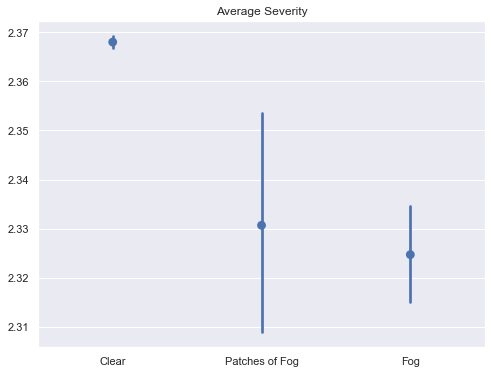

In [35]:
sns.set(rc={'figure.figsize':(8,6)})

pfog_acdnts2 = acdnts2[(acdnts2['Weather_Condition'] == 'Patches of Fog')]
fog_acdnts2 = acdnts2[(acdnts2['Weather_Condition'] == 'Fog')]

g = sns.pointplot(data=[clr_acdnts2['Severity'],
                        pfog_acdnts2['Severity'],
                        fog_acdnts2['Severity']], join=False)
                       
g.set(xticklabels = ['Clear', 'Patches of Fog', 'Fog'])
plt.title('Average Severity');

In [36]:
print('Clear and Patches of Fog:')
print(stats.ttest_ind(clr_acdnts2['Severity'], pfog_acdnts2['Severity']))
print('---')

print('Clear and Fog:')
print(stats.ttest_ind(clr_acdnts2['Severity'], fog_acdnts2['Severity']))
print('---')

print('Patches of Fog and Fog:')
print(stats.ttest_ind(pfog_acdnts2['Severity'], fog_acdnts2['Severity']))

Clear and Patches of Fog:
Ttest_indResult(statistic=2.957143846257196, pvalue=0.0031051218230721276)
---
Clear and Fog:
Ttest_indResult(statistic=8.479281107865944, pvalue=2.2695696146689358e-17)
---
Patches of Fog and Fog:
Ttest_indResult(statistic=0.44516263427144764, pvalue=0.6562093688283717)


In [37]:
print(get_95_ci(clr_acdnts2['Severity'], fog_acdnts2['Severity']))

The difference in means at the 95% confidence interval (two-tail) is between -0.053311687599648765 and -0.033327412007653996.


Average severity is lower in fog than in clear conditions. With 95% confidence, average severity in fog is between 0.053 and 0.033 points lower. This may be because people drive slower in fog.

# Exploring severity 4 accidents
My analysis so far has not provided any insight into when the most severe accidents occur. I'll look at these records next.

In [38]:
acdnts_4 = acdnts[acdnts['Severity']==4]
acdnts_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72002 entries, 619 to 2243938
Data columns (total 49 columns):
ID                       72002 non-null object
Source                   72002 non-null object
TMC                      1427 non-null float64
Severity                 72002 non-null int64
Start_Time               72002 non-null object
End_Time                 72002 non-null object
Start_Lat                72002 non-null float64
Start_Lng                72002 non-null float64
End_Lat                  70575 non-null float64
End_Lng                  70575 non-null float64
Distance(mi)             72002 non-null float64
Description              72002 non-null object
Number                   32854 non-null float64
Street                   72002 non-null object
Side                     72002 non-null object
City                     71990 non-null object
County                   72002 non-null object
State                    72002 non-null object
Zipcode                  71942 non-n

In [39]:
acdnts_4.describe().round(2)

,TMC,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Number,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,1427.00,72002.0,72002.00,72002.00,70575.00,70575.00,72002.00,32854.00,68779.00,17442.00,68673.00,68993.00,68323.00,55248.00,72002.00
mean,231.39,4.0,38.02,-89.39,38.10,-89.36,1.62,7929.38,56.91,24.90,68.49,30.04,9.07,8.98,0.01
std,61.80,0.0,4.85,15.01,4.81,15.03,3.55,16648.32,20.29,13.32,22.29,0.21,3.25,5.30,0.11
min,200.00,4.0,24.57,-124.46,24.57,-124.42,0.00,1.00,-40.00,-65.90,4.00,26.85,0.00,1.20,0.00
25%,201.00,4.0,34.14,-95.37,34.22,-95.30,0.23,1100.00,41.20,17.90,53.00,29.92,10.00,5.80,0.00
50%,201.00,4.0,39.24,-84.11,39.28,-84.08,0.61,3699.00,59.00,27.15,71.00,30.04,10.00,8.10,0.00
75%,241.00,4.0,41.32,-78.32,41.35,-78.23,1.63,9206.00,73.00,35.10,87.00,30.17,10.00,11.50,0.00
max,406.00,4.0,49.00,-67.61,49.08,-67.61,138.91,961043.00,117.00,45.20,100.00,31.12,80.00,471.80,10.02


The mean visibility is 9.07 miles, and the mean precipitation is .01 inches, again suggesting clear conditions. These averages are very close to the averages we saw in the full dataset. However, temperature is about 4 degrees lower, and humidity is about 2.5% higher. These may be variables to consider in the future.

Let's see where most severity level 4 accidents happened in the U.S.

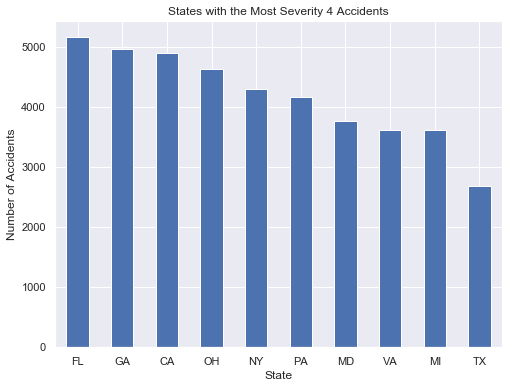

In [40]:
acdnts_4['State'].value_counts().head(10).plot('bar')
plt.xlabel('State')
plt.xticks(rotation=0)
plt.ylabel('Number of Accidents')
plt.title('States with the Most Severity 4 Accidents')
plt.show()

I was surprised that Florida, the 'Sunshine State', the most severity 4 accidents, followed by Georgia.

I'll create dataframes representing all accidents in each of these states, then use the latitude and longitude variables to plot them. If cityscaping and/or demographics impact severity, I would expect to see severity concentrated in specific parts of each state.

In [41]:
acdnts_FL = acdnts[acdnts['State']=='FL']
acdnts_GA = acdnts[acdnts['State']=='GA']

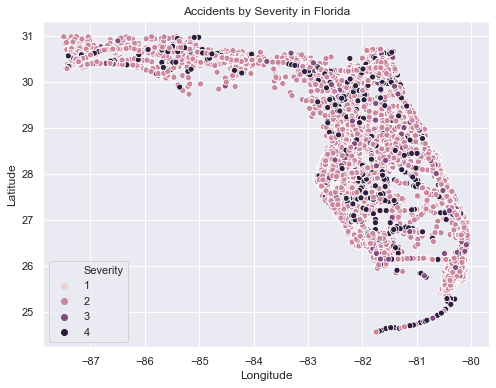

In [42]:
sns.scatterplot(x='Start_Lng', y='Start_Lat', data=acdnts_FL, hue='Severity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Accidents by Severity in Florida')
plt.show()

In [43]:
# Creating a df to get a clearer picture of severity 4's across FL
acdnts_FL_4 = acdnts_FL[acdnts_FL['Severity']==4]

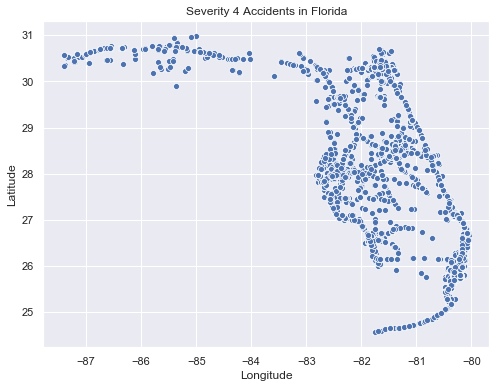

In [44]:
sns.scatterplot(x='Start_Lng', y='Start_Lat', data=acdnts_FL_4)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Severity 4 Accidents in Florida')
plt.show()

Most accidents in Florida are severity level 2, with more severe accidents disbursed throughout the state.

There does appear to be a higher concentration of severe accidents on the southern peninsula. In future analysis, it would be interesting to look at similar land formations across this dataset to see if there is a trend. 

Let's look at Georgia.

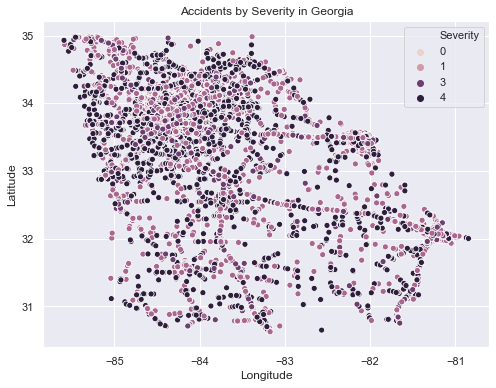

In [45]:
sns.scatterplot(x='Start_Lng', y='Start_Lat', data=acdnts_GA, hue='Severity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Accidents by Severity in Georgia')
plt.show()

In [46]:
# Creating a df to get a clearer picture of severity 4's across GA
acdnts_GA_4 = acdnts_GA[acdnts_GA['Severity']==4]

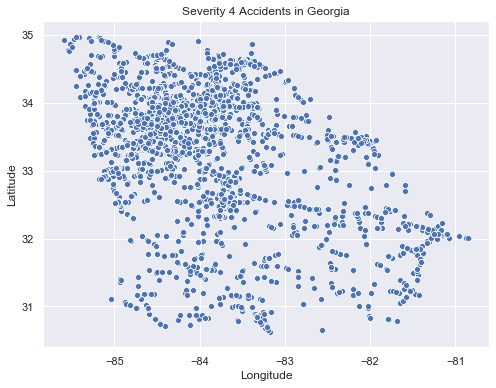

In [47]:
sns.scatterplot(x='Start_Lng', y='Start_Lat', data=acdnts_GA_4)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Severity 4 Accidents in Georgia')
plt.show()

Compared to Florida, Georgia has a higher percentage of severity level 4 accidents. There are more accidents in the northern part of the state, but severity levels appear evenly distributed.

# Conclusions
### Does weather affect accident occurrence?
I did not find a correlation between adverse weather and accident occurrence. However, this dataset is imbalanced, with most records showing clear weather. The imbalance could be a reflection of average weather across the U.S. or when most drivers are on the road.

### Does weather affect an accident's impact on traffic?
There is not a meaningful correlation between accident severity and precipitation or accident severity and visibility. However, I found small but statistically significant differences in average severity levels between clear, light rain, and rain conditons; as well as clear and fog conditions. 

### For future research:
I recommend combining this dataset with a dataset containing weather conditions in a given time and location to determine the likelihood of traffic accidents in different kinds of weather. I also suggest looking further into possible data collection errors here by comparing numerical weather variables, such as precipitaiton, with the weather condition field.

Additionally, The Urban Institute tracks highway and road expenditures by state, using data from the U.S. Census Bureau. Interestingly, Florida and Georgia are among the states reported to spend the least per capita. For further analysis, I would recommend exploring if accidents and accident severity correlate with state spending. Urban Institute data is available here: https://www.urban.org/policy-centers/cross-center-initiatives/state-and-local-finance-initiative/state-and-local-backgrounders/highway-and-road-expenditures

# Acknowledgments
Thank you to Sobhan Moosavi for making this dataset available.

Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, and Rajiv Ramnath. “A Countrywide Traffic Accident Dataset.”, arXiv preprint arXiv:1906.05409 (2019).

Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, Radu Teodorescu, and Rajiv Ramnath. “Accident Risk Prediction based on Heterogeneous Sparse Data: New Dataset and Insights.” In proceedings of the 27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, ACM, 2019.